In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
import joblib

In [42]:
from datasets import load_dataset

dataset = load_dataset("papluca/language-identification")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})


In [43]:
print("Loading dataset...")
dataset = load_dataset("papluca/language-identification")
train_data = dataset['train'].to_pandas()
valid_data = dataset['validation'].to_pandas()
test_data = dataset['test'].to_pandas()
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")

Loading dataset...
Train samples: 70000
Validation samples: 10000
Test samples: 10000


In [44]:
train_data.sample(5)

,labels,text
351,en,Not a fan. The color is dull and the quality i...
15933,fr,Franchement l’article es comme sur la photo sa...
24592,hi,"पहले , maggert नाश ."
18047,el,Τα δυνατά πόδια του καλ Πάτησαν μπροστά από τη...
23285,it,Un ragazzino va in bicicletta.


In [45]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  70000 non-null  object
 1   text    70000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [46]:
train_data.duplicated().sum()

1020

In [47]:
train_data = train_data.drop_duplicates()

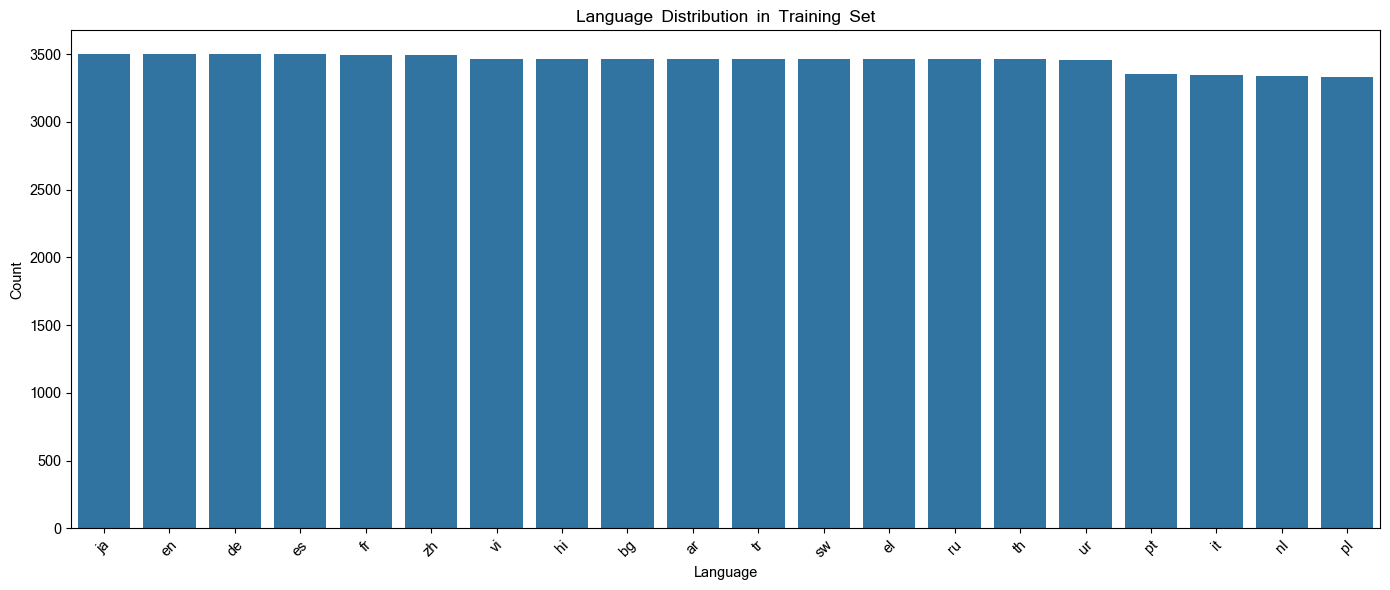

In [48]:
plt.figure(figsize=(14,6))
sns.countplot(x='labels', data=train_data, order=train_data['labels'].value_counts().index)
plt.title('Language Distribution in Training Set')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

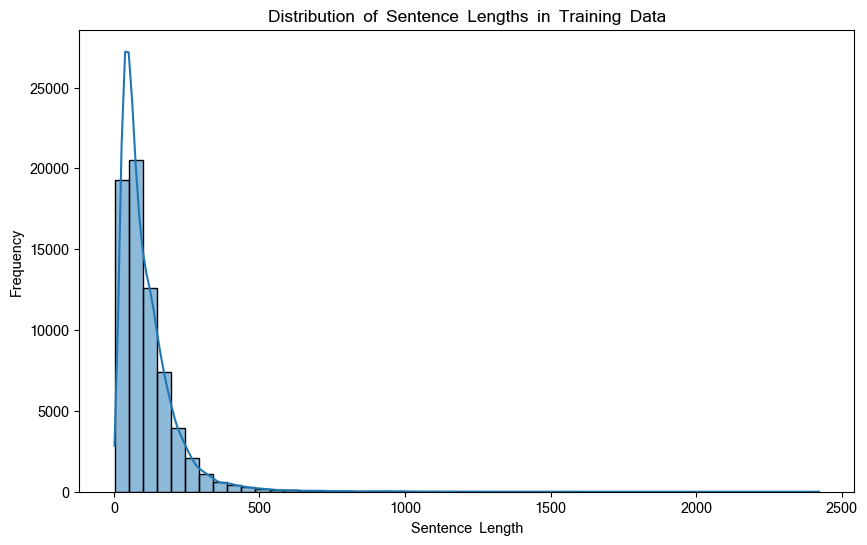

In [49]:
train_data['text_len'] = train_data['text'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(train_data['text_len'], bins=50, kde=True)
plt.title('Distribution of Sentence Lengths in Training Data')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

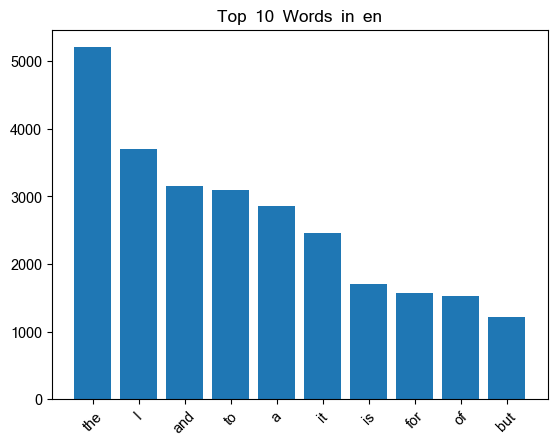

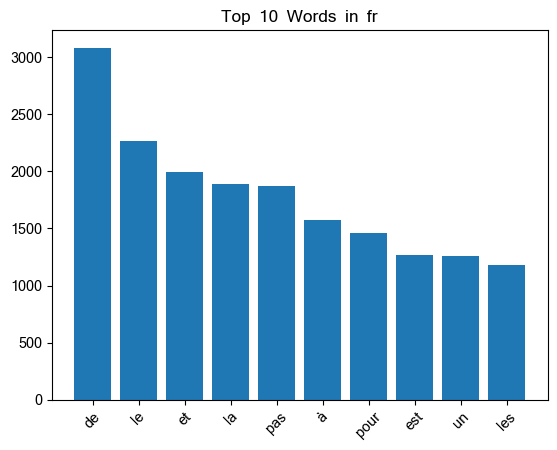

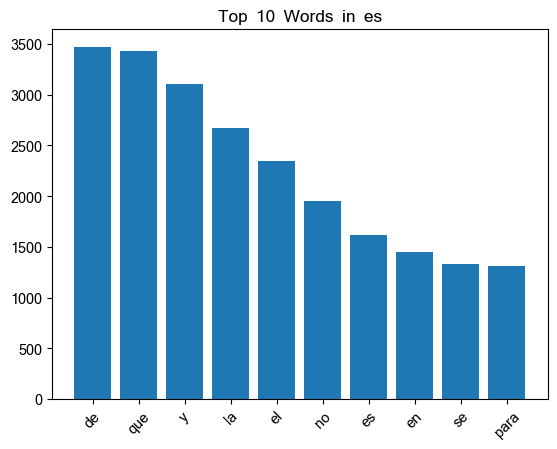

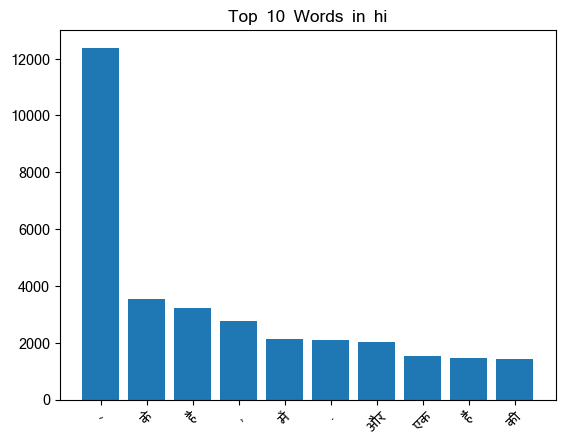

In [52]:
from collections import Counter
def plot_top_words(lang, n=10):
    texts = train_data[train_data['labels']==lang]['text']
    words = ' '.join(texts).split()
    common_words = Counter(words).most_common(n)
    words, counts = zip(*common_words)
    plt.bar(words, counts)
    plt.title(f"Top {n} Words in {lang}")
    plt.xticks(rotation=45)
    plt.show()

for lang in ['en', 'fr', 'es','hi']:
    plot_top_words(lang)

In [53]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['labels'])
valid_labels = label_encoder.transform(valid_data['labels'])
test_labels = label_encoder.transform(test_data['labels'])

In [54]:
max_words = 50000
max_len = 75
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['text'])
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
valid_sequences = tokenizer.texts_to_sequences(valid_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
valid_padded = pad_sequences(valid_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [55]:
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    LSTM(32),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(len(label_encoder.classes_), activation='softmax')
])

C:\Users\samra\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [56]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

In [59]:
history = model.fit(
    train_padded, train_labels,
    validation_data=(valid_padded, valid_labels),
    epochs=20,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 140s 241ms/step - accuracy: 0.1552 - loss: 2.6152 - val_accuracy: 0.4571 - val_loss: 1.5455
Epoch 2/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 124s 229ms/step - accuracy: 0.6144 - loss: 0.9914 - val_accuracy: 0.6939 - val_loss: 1.0261
Epoch 3/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 141s 228ms/step - accuracy: 0.8053 - loss: 0.5385 - val_accuracy: 0.8574 - val_loss: 0.6401
Epoch 4/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 140s 225ms/step - accuracy: 0.9108 - loss: 0.2757 - val_accuracy: 0.8503 - val_loss: 0.6759
Epoch 5/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 142s 225ms/step - accuracy: 0.9296 - loss: 0.1949 - val_accuracy: 0.8875 - val_loss: 0.6222
Epoch 6/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 116s 215ms/step - accuracy: 0.9424 - loss: 0.1648 - val_accuracy: 0.8689 - val_loss: 0.6206
Epoch 7/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 141s 213ms/step - accuracy: 0.9488 - loss: 0.1402 - val_accuracy: 0.8894 - val_loss: 0.5988
Epoch 8/20
539/539 ━━━━━━━━━━━━━━━━━━━━ 120s 222ms/step - accuracy: 0.9513 -

In [60]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 75, 128)             │       6,400,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 75, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,396,222 (73.99 MB)

 Trainable params: 6,465,364 (24.66 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 12,930,730 (49.33 MB)

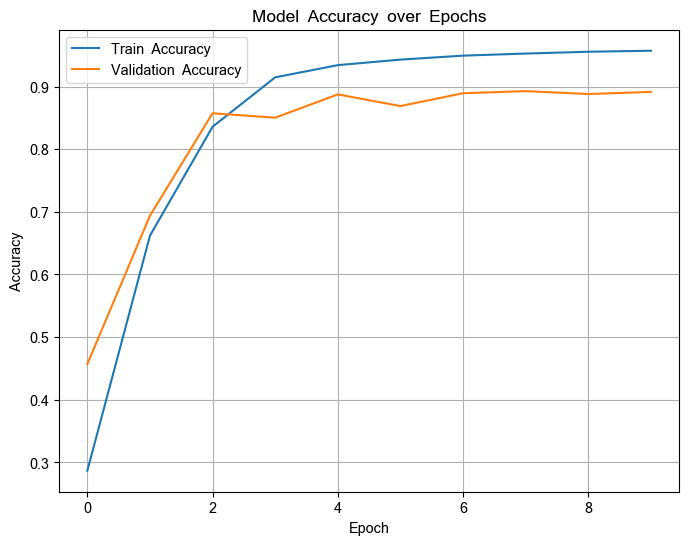

In [61]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

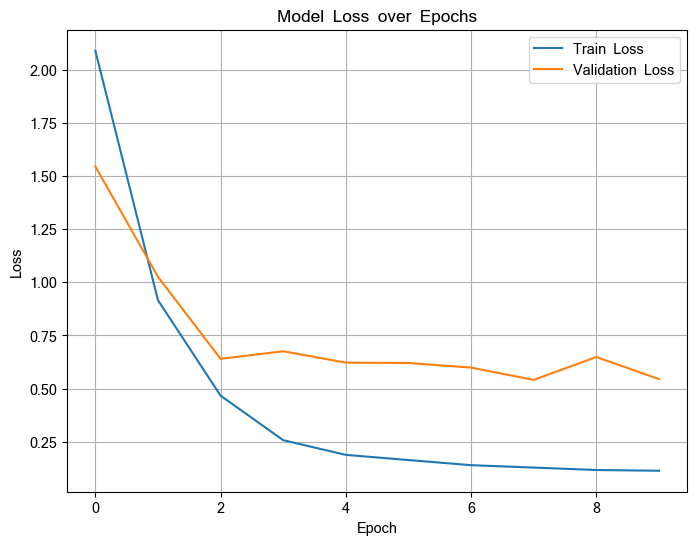

In [62]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8896 - loss: 0.5604
Test Accuracy: 0.8866


In [64]:
predictions = model.predict(test_padded)
pred_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, pred_labels, target_names=label_encoder.classes_))

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step
              precision    recall  f1-score   support

          ar       0.99      0.82      0.89       500
          bg       0.92      0.97      0.94       500
          de       0.97      1.00      0.99       500
          el       1.00      0.99      1.00       500
          en       1.00      0.99      0.99       500
          es       0.98      1.00      0.99       500
          fr       0.99      0.99      0.99       500
          hi       0.99      0.92      0.95       500
          it       0.98      0.96      0.97       500
          ja       0.38      0.58      0.46       500
          nl       0.88      0.98      0.93       500
          pl       0.88      0.94      0.91       500
          pt       1.00      0.94      0.97       500
          ru       0.94      0.90      0.92       500
          sw       0.98      0.97      0.98       500
          th       0.80      0.23      0.35       500
          tr       0.93      0.87     

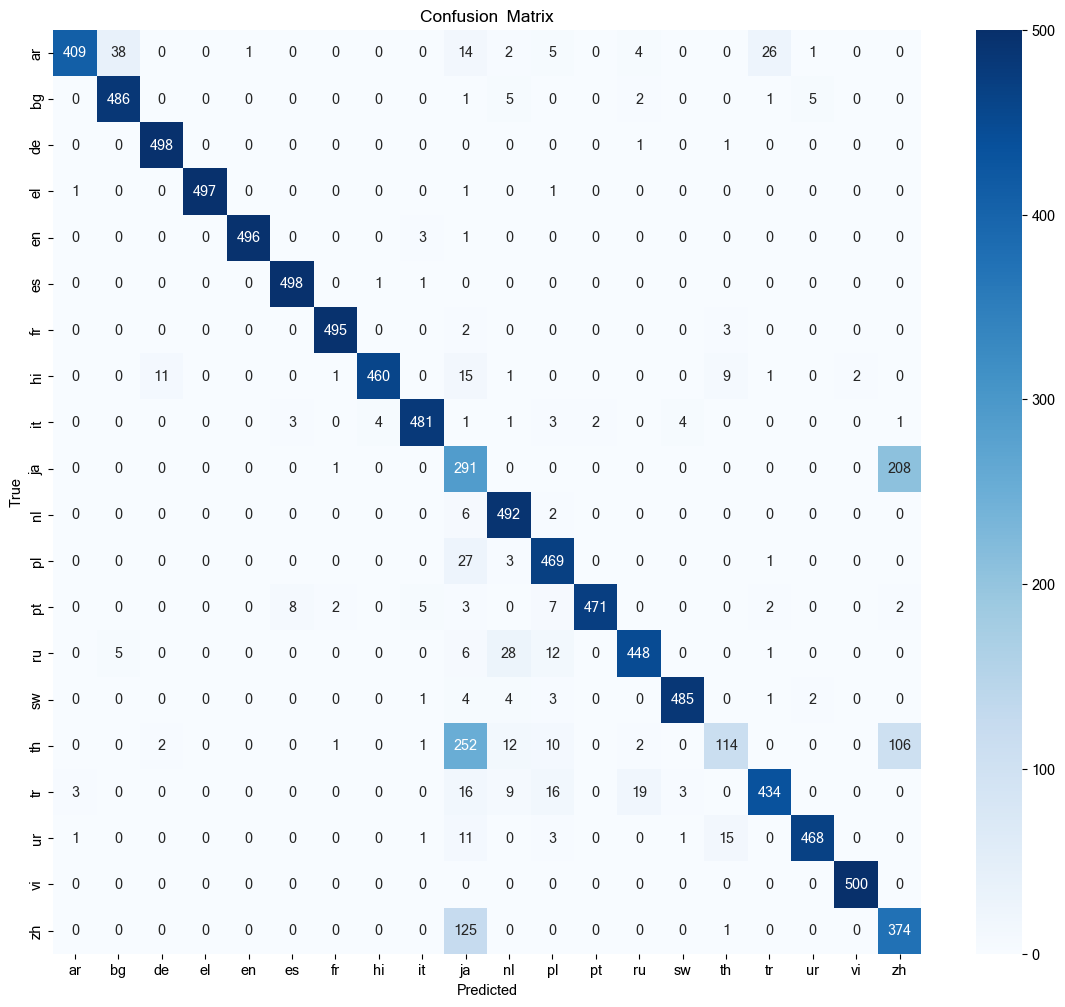

In [65]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14,12))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_labels, pred_labels, label_encoder.classes_)

In [3]:
model = load_model("language_id_lstm_model.h5")

In [7]:
model.save("language_id_lstm_model.keras", include_optimizer=False)